# Importar liberías

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import os
from wordcloud import WordCloud

2025-03-30 20:50:29.030962: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743378629.041920   35009 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743378629.045243   35009 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743378629.054560   35009 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743378629.054568   35009 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743378629.054569   35009 computation_placer.cc:177] computation placer alr

# Carga del dataset

In [3]:
# Cargar el conjunto de datos 'ag_news_subset' de tensorflow_datasets
ds, info = tfds.load('ag_news_subset', with_info=True, as_supervised=True)
train_ds, test_ds = ds['train'], ds['test']

W0000 00:00:1743378630.888877   35009 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Visualización de datos

In [4]:
# Obtener la longitud del dataset
train_length = tf.data.experimental.cardinality(train_ds).numpy()
test_length = tf.data.experimental.cardinality(test_ds).numpy()

print("Longitud del conjunto de entrenamiento:", train_length)
print("Longitud del conjunto de prueba:", test_length)

Longitud del conjunto de entrenamiento: 120000
Longitud del conjunto de prueba: 7600


In [5]:
# Imprimir la cantidad y los nombres de las clases
print(info.features["label"].num_classes)
print(info.features["label"].names)

4
['World', 'Sports', 'Business', 'Sci/Tech']


In [6]:
# Mostrar los primeros 5 ejemplos del conjunto de datos de entrenamiento
tfds.as_dataframe(train_ds.take(5), info)

2025-03-30 20:50:31.010215: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-30 20:50:31.016460: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-30 20:50:31.016619: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)


Vemos que el dataset está compuesto por más de 120.000 artículos divididos en train y test. Los mísmos están clasificados con cuatro tipo de etiquetas según su contenido.

## Distribución de longitudes

2025-03-30 20:50:43.193656: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Media de longitudes: 193.40201666666667
Mediana de longitudes: 188.0
Desviación estándar de longitudes: 64.4517376228114
Longitud mínima: 20
Longitud máxima: 985
Percentil 25: 155.0
Percentil 50 (mediana): 188.0
Percentil 75: 219.0


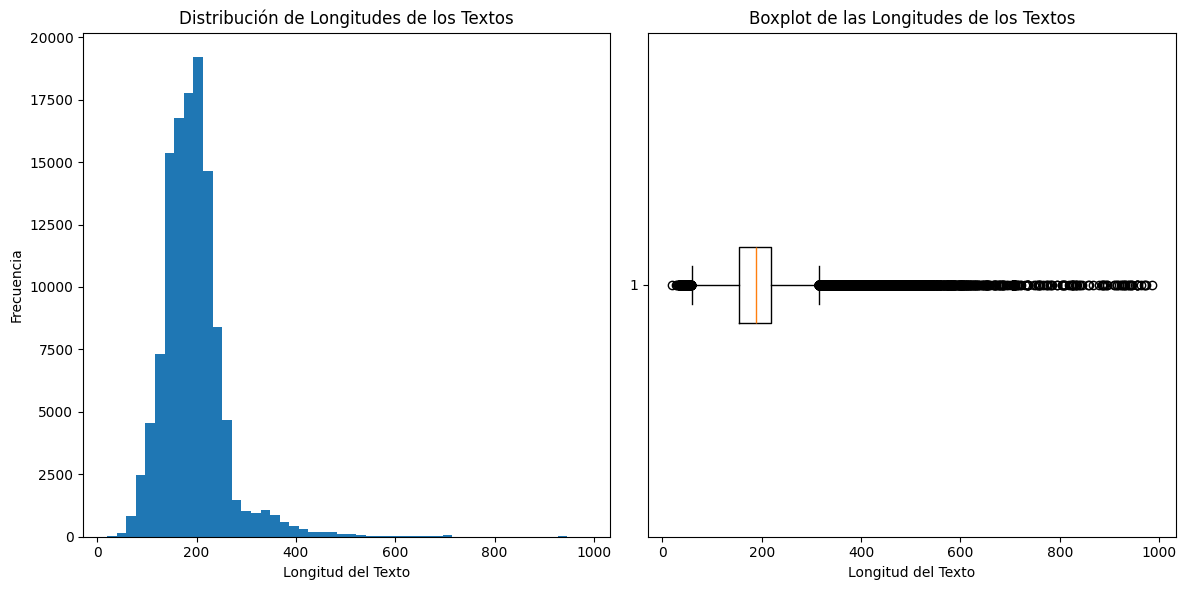

In [7]:
# Obtener longitudes de los textos
text_lengths = [len(text.numpy().decode('utf-8')) for text, label in train_ds]

# Calcular estadísticas descriptivas
mean_length = np.mean(text_lengths)
median_length = np.median(text_lengths)
std_length = np.std(text_lengths)
min_length = np.min(text_lengths)
max_length = np.max(text_lengths)
percentiles = np.percentile(text_lengths, [25, 50, 75])

# Imprimir estadísticas descriptivas
print(f"Media de longitudes: {mean_length}")
print(f"Mediana de longitudes: {median_length}")
print(f"Desviación estándar de longitudes: {std_length}")
print(f"Longitud mínima: {min_length}")
print(f"Longitud máxima: {max_length}")
print(f"Percentil 25: {percentiles[0]}")
print(f"Percentil 50 (mediana): {percentiles[1]}")
print(f"Percentil 75: {percentiles[2]}")

# Crear una figura con dos subgráficos
plt.figure(figsize=(12, 6))

# Subgráfico 1: Histograma
plt.subplot(1, 2, 1)
plt.hist(text_lengths, bins=50)
plt.xlabel('Longitud del Texto')
plt.ylabel('Frecuencia')
plt.title('Distribución de Longitudes de los Textos')

# Subgráfico 2: Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(text_lengths, vert=False)
plt.xlabel('Longitud del Texto')
plt.title('Boxplot de las Longitudes de los Textos')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

Calculamos las estadísticas descriptivas y ploteamos dos gráficos de la distribución de longitudes de los textos del dataset.
Vemos que, más alla de tener longitudes de hasta casi 1000 caracteres, la mayoría de los valores se concentran en torno al valor 200. Teniendo el 75% de los valores menores o igual a 219 caracteres.

## Distribución de clases

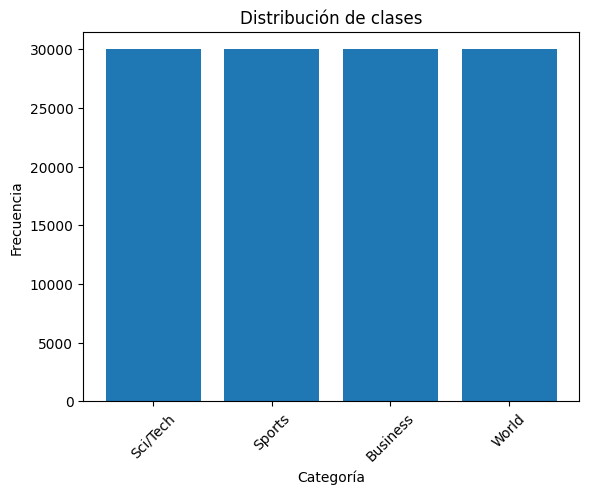

In [8]:
# Obtener las etiquetas
labels = [label.numpy() for text, label in train_ds]

# Contar la frecuencia de cada etiqueta
label_count = Counter(labels)

# Obtener los nombres de las etiquetas desde info
label_names = info.features['label'].int2str

# Preparar los datos para el gráfico
classes = [label_names(key) for key in label_count.keys()]
counts = list(label_count.values())

# Crear el gráfico de barras
plt.bar(classes, counts)
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de clases')
plt.xticks(rotation=45)
plt.show()

## Palabras más comunes

2025-03-30 20:51:08.177819: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


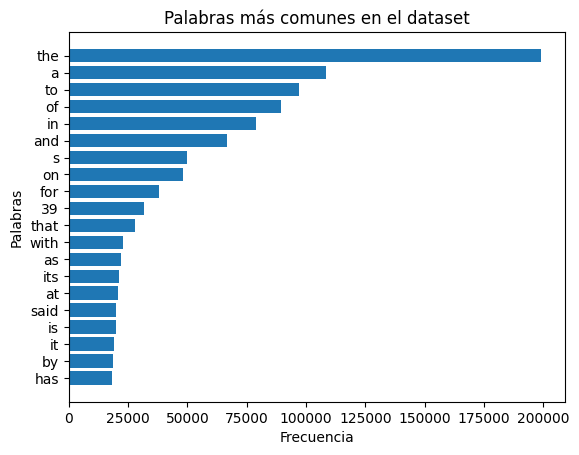

In [9]:
# Inicializar el contador
word_count = Counter()

# Iterar sobre el conjunto de datos de entrenamiento para contar palabras
for text, label in train_ds:
    words = re.findall(r'\b\w+\b', text.numpy().decode('utf-8').lower())
    word_count.update(words)

# Mostrar las 20 palabras más comunes
most_common_words = word_count.most_common(20)

# Visualizar las palabras más comunes en un gráfico de barras horizontal
words, counts = zip(*most_common_words)
plt.barh(words, counts)
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('Palabras más comunes en el dataset')
plt.gca().invert_yaxis()
plt.show()

Relizamos el mismo proceso pero eliminando las stop words:

[nltk_data] Downloading package stopwords to /home/edus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


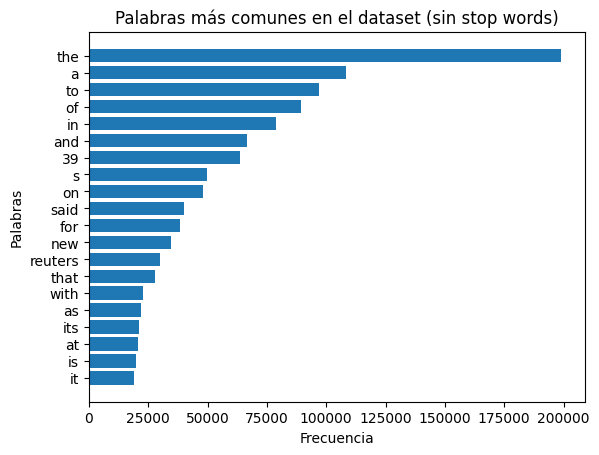

In [10]:
# Descargar las stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Iterar sobre el conjunto de datos de entrenamiento para contar palabras, eliminando las stop words
for text, label in train_ds:
    words = re.findall(r'\b\w+\b', text.numpy().decode('utf-8').lower())
    filtered_words = [word for word in words if word not in stop_words]
    word_count.update(filtered_words)

# Mostrar las 20 palabras más comunes
most_common_words = word_count.most_common(20)

# Visualizar las palabras más comunes en un gráfico de barras horizontal
words, counts = zip(*most_common_words)
plt.barh(words, counts)
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('Palabras más comunes en el dataset (sin stop words)')
plt.gca().invert_yaxis()
plt.show()

## Nube de palabras

In [ ]:
# Convertir el dataset a un solo string
text_data = ' '.join([text.numpy().decode('utf-8') for text, label in train_ds])

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras del Dataset de Texto')
plt.show()

# Modelo por caracter

## Preprocesamiento de texto

Como primer paso, vamos a pasar todos los textos contenidos en los datasets de train y test a string para poder utilizarlo en el entrenamiento del modelo.
Para ello, creamos la siguiente función:

In [ ]:
# Función para convertir un dataset a texto
def dataset_to_text(dataset):
    text_data = ''
    for text, label in dataset:
        text_data += text.numpy().decode('utf-8') + ' '
    return text_data

# Convertir train_ds y test_ds a texto
train_text = dataset_to_text(train_ds)
test_text = dataset_to_text(test_ds)

# Mostrar las primeras 500 caracteres de cada texto
print("Primeros 500 caracteres del train_text:\n", train_text[:500])
print("\nPrimeros 500 caracteres del test_text:\n", test_text[:500])

Primeros 500 caracteres del train_text:
 AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions. Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season. President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local

Primeros 500 caracteres del test_text:
  CHARLOTTE, N.C. (Sports Network) - Carolina Panthers  running back Stephen Davis will miss the remainder of the  season after being placed on injured reserve Saturday.  PRESENTACION, Philippines (Reuters) - Philippine communist  rebels freed Wednesday two soldiers they had held as "prisoners  of war" for more than five months, saying they wanted to  rebuild confidence in peace talks with the government. SAN FRANC

Para este modelo, hacemos una limpieza del texto a nivel de caracteres, convirtiendo las mayúsculas a minúsculas y eliminando los caracteres no alfabéticos.

In [ ]:
# Función para preprocesar texto a nivel de caracteres
def preprocess_text_char(text):
    text = tf.strings.lower(text) # Convertir a minúsculas
    #text = tf.strings.regex_replace(text, '[^a-z ]', '')  # Eliminar caracteres no alfabéticos
    return text

train_text_processed = preprocess_text_char(train_text).numpy().decode('utf-8')
test_text_processed = preprocess_text_char(test_text).numpy().decode('utf-8')

print("Primeros 500 caracteres del train_text_processed:\n", train_text_processed[:500])

Primeros 500 caracteres del train_text_processed:
 amd #39;s new dual-core opteron chip is designed mainly for corporate computing applications, including databases, web services, and financial transactions. reuters - major league baseball\monday announced a decision on the appeal filed by chicago cubs\pitcher kerry wood regarding a suspension stemming from an\incident earlier this season. president bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local


In [ ]:
# Caracteres únicos en el texto procesado
vocab = sorted(set(train_text_processed))
print(f'{len(vocab)} caracteres únicos')

56 caracteres únicos


Luego, utilizamos TensorFlow para convertir caracteres a IDs y viceversa. 'ids_from_chars' es una capa que toma un vocabulario de caracteres y puede mapear cualquier carácter en este vocabulario a un ID único y 'chars_from_ids' es la capa inversa, que toma IDs y los convierte de nuevo en caracteres utilizando el mismo vocabulario.
A continuación, se define una función llamada text_from_ids que toma una secuencia de IDs y los convierte en texto concatenando los caracteres correspondientes. Esto es útil para verificar que el mapeo de IDs a caracteres se haya realizado correctamente.

In [ ]:
# Crear mapeos de caracteres a IDs y viceversa
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Aquí, se convierte todo el texto de entrenamiento (train_text) en IDs de caracteres. Esto se hace dividiendo el texto en caracteres individuales y utilizando la capa 'ids_from_chars' para mapear cada carácter a su correspondiente ID.

In [ ]:
# Convertir texto a IDs
train_ids = ids_from_chars(tf.strings.unicode_split(train_text_processed, 'UTF-8'))
val_ids = ids_from_chars(tf.strings.unicode_split(test_text_processed, 'UTF-8'))

Estos IDs se utilizan para crear un dataset de TensorFlow, 'ids_dataset', donde cada elemento del dataset es un solo ID de carácter.

In [ ]:
# Crear datasets de IDs
train_ids_dataset = tf.data.Dataset.from_tensor_slices(train_ids)
val_ids_dataset = tf.data.Dataset.from_tensor_slices(val_ids)

In [ ]:
# Mostrar los primeros 10 IDs convertidos a caracteres
for ids in train_ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

a
m
d
 
#
3
9
;
s
 


El siguiente paso es formar secuencias de longitud fija a partir de este dataset de IDs. Se define una longitud de secuencia (seq_length) de 100 caracteres. El dataset se agrupa en lotes de tamaño seq_length + 1 (101 caracteres en total) para formar las secuencias. Esto asegura que cada secuencia tenga la longitud adecuada para el entrenamiento del modelo. Se imprimen algunas de estas secuencias para verificar su contenido.

In [ ]:
# Definir longitud de secuencia
seq_length = 100

# Crear secuencias de IDs
train_sequences = train_ids_dataset.batch(seq_length + 1, drop_remainder=True)
val_sequences = val_ids_dataset.batch(seq_length + 1, drop_remainder=True)


# Mostrar una secuencia de ejemplo
for seq in train_sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'a' b'm' b'd' b' ' b'#' b'3' b'9' b';' b's' b' ' b'n' b'e' b'w' b' '
 b'd' b'u' b'a' b'l' b'-' b'c' b'o' b'r' b'e' b' ' b'o' b'p' b't' b'e'
 b'r' b'o' b'n' b' ' b'c' b'h' b'i' b'p' b' ' b'i' b's' b' ' b'd' b'e'
 b's' b'i' b'g' b'n' b'e' b'd' b' ' b'm' b'a' b'i' b'n' b'l' b'y' b' '
 b'f' b'o' b'r' b' ' b'c' b'o' b'r' b'p' b'o' b'r' b'a' b't' b'e' b' '
 b'c' b'o' b'm' b'p' b'u' b't' b'i' b'n' b'g' b' ' b'a' b'p' b'p' b'l'
 b'i' b'c' b'a' b't' b'i' b'o' b'n' b's' b',' b' ' b'i' b'n' b'c' b'l'
 b'u' b'd' b'i'], shape=(101,), dtype=string)


In [ ]:
# Mostrar las primeras 5 secuencias de ejemplo
for seq in train_sequences.take(5):
  print(text_from_ids(seq).numpy())

b'amd #39;s new dual-core opteron chip is designed mainly for corporate computing applications, includi'
b'ng databases, web services, and financial transactions. reuters - major league baseball\\monday announ'
b'ced a decision on the appeal filed by chicago cubs\\pitcher kerry wood regarding a suspension stemming'
b' from an\\incident earlier this season. president bush #39;s  quot;revenue-neutral quot; tax reform ne'
b'eds losers to balance its winners, and people claiming the federal deduction for state and local taxe'


Luego, se define una función 'split_input_target' que divide cada secuencia en dos partes: la secuencia de entrada y la secuencia objetivo. La secuencia de entrada contiene todos los caracteres excepto el último, y la secuencia objetivo contiene todos los caracteres excepto el primero. Esto crea pares de datos que se utilizan para entrenar el modelo: dado un texto de entrada, el modelo aprende a predecir el siguiente carácter. Se aplica esta función de división a todo el dataset de secuencias.

In [ ]:
# Función para dividir la secuencia en entrada y objetivo
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

# Aplicar la función a los datasets
train_dataset = train_sequences.map(split_input_target)
val_dataset = val_sequences.map(split_input_target)

In [ ]:
# Mostrar un ejemplo de entrada y objetivo
for input_example, target_example in train_dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'amd #39;s new dual-core opteron chip is designed mainly for corporate computing applications, includ'
Target: b'md #39;s new dual-core opteron chip is designed mainly for corporate computing applications, includi'


## Construcción

Este código define y entrena un modelo de red neuronal recurrente para la generación de texto a nivel de caracteres utilizando TensorFlow. Primero, se especifica el tamaño del lote para la capacitación y se define un tamaño de buffer para barajar el conjunto de datos. Luego, se crea el dataset de entrenamiento, que se baraja, agrupa en lotes y prefetch para mejorar el rendimiento durante el entrenamiento.

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size para barajar el dataset
BUFFER_SIZE = 10000

# Crear datasets de entrenamiento y validación
train_dataset = (
    train_dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

val_dataset = (
    val_dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

Se definen los hiperparámetros del modelo, incluido el tamaño del vocabulario, la dimensión de la capa de embedding y el número de unidades de la red recurrente. El modelo se define mediante una clase personalizada que extiende tf.keras.Model. Esta clase tiene una capa de embedding para convertir los índices de caracteres en vectores densos, una capa GRU para manejar la secuencia de datos y una capa densa para generar la predicción de caracteres.

In [ ]:
# Definir hiperparámetros del modelo
vocab_size = len(ids_from_chars.get_vocabulary())
embedding_dim = 256
rnn_units = 384

In [ ]:
# Definir el modelo
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
# Crear instancia del modelo
character_model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
# Probar el modelo con una entrada de ejemplo
for input_example_batch, target_example_batch in train_dataset.take(1):
    example_batch_predictions = character_model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 57) # (batch_size, sequence_length, vocab_size)


## Entrenamiento

Para el entrenamiento, se establece la función de pérdida como SparseCategoricalCrossentropy, que es adecuada para problemas de clasificación categórica con clases exclusivas. El modelo se compila con el optimizador Adam, conocido por su eficiencia en la práctica y buenos resultados.

In [ ]:
# Definir la pérdida
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compilar el modelo
character_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss)

character_model.summary()

Model: "my_model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     multiple                  14592     
                                                                 
 gru_7 (GRU)                 multiple                  739584    
                                                                 
 dense_7 (Dense)             multiple                  21945     
                                                                 
Total params: 776,121
Trainable params: 776,121
Non-trainable params: 0
_________________________________________________________________


Se definen dos callbacks para el entrenamiento: ModelCheckpoint y EarlyStopping. El primero guarda los pesos del modelo después de cada época si la pérdida mejora, mientras que el segundo detiene el entrenamiento si la pérdida no mejora durante tres épocas consecutivas, restaurando los mejores pesos encontrados durante el entrenamiento.

In [ ]:
# Definir callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
# Definir número de épocas
EPOCHS = 10

# Entrenar el modelo
history = character_model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=[early_stopping_callback])

Guardamos los pesos creados por el modelo:

In [ ]:
# Definir el nombre del archivo donde guardar los pesos
weights_file = '/home/rama811/Escritorio/tp_final_aa2/character_model_weights.h5'

# Guardar los pesos del modelo
character_model.save_weights(weights_file)

# Confirmación de guardado
print("Pesos del modelo guardados correctamente en:", weights_file)

In [ ]:
# Definir el nombre del archivo donde cargar los pesos
weights_file = '/home/rama811/Escritorio/tp_final_aa2/character_model_weights_4.h5'

# Cargar los pesos del modelo
character_model.load_weights(weights_file)

# Confirmación de cargado
print("Pesos del modelo cargados correctamente en:", weights_file)

Pesos del modelo cargados correctamente en: /home/rama811/Escritorio/tp_final_aa2/character_model_weights_4.h5


Probamos con un modelo más complejo:

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units, dropout_rate=0.2):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru1 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True)
    self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
    self.gru2 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True)
    self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru1.get_initial_state(x)
    x, states = self.gru1(x, initial_state=states, training=training)
    x = self.dropout1(x, training=training)
    x, states = self.gru2(x, initial_state=states, training=training)
    x = self.dropout2(x, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

# Parámetros del modelo
vocab_size = len(ids_from_chars.get_vocabulary())
embedding_dim = 256
rnn_units = 256
dropout_rate = 0.3

# Instanciar el modelo
character_model_2 = MyModel(vocab_size, embedding_dim, rnn_units, dropout_rate)

# Compilar el modelo
character_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# Resumen del modelo
character_model_2.build(tf.TensorShape([None, None]))
character_model_2.summary()

In [ ]:
history = character_model_2.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=early_stopping_callback)

In [ ]:
# Definir el nombre del archivo donde guardar los pesos
weights_file = '/home/rama811/Escritorio/tp_final_aa2/character_model_2_weights.h5'

# Guardar los pesos del modelo
character_model_2.save_weights(weights_file)

# Confirmación de guardado
print("Pesos del modelo guardados correctamente en:", weights_file)

## Generación de texto

La clase OneStep hereda de tf.keras.Model y se utiliza para generar texto carácter por carácter, manejando el proceso de predicción y ajustando la aleatoriedad de las predicciones mediante un parámetro de temperatura.
Para evitar la generación de tokens desconocidos ("[UNK]"), se crea una máscara que asigna un valor de probabilidad negativo infinito a estos tokens.
El método generate_one_step se define como una función de TensorFlow que toma una entrada de texto y un estado opcional del modelo. Convierte la entrada de texto en IDs de tokens, los pasa a través del modelo para obtener las predicciones de los logits, y ajusta estos logits utilizando la temperatura y la máscara de predicción. Luego, se realiza un muestreo de estos logits para obtener los IDs de los siguientes caracteres y se convierten nuevamente en caracteres.

In [ ]:
def generate_text_character(query, model):

  # Definición de la clase OneStep que hereda de tf.keras.Model
  class OneStep(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
      super().__init__()
      self.temperature = temperature # Temperatura para ajustar la aleatoriedad de las predicciones
      self.model = model # Modelo de generación de texto
      self.chars_from_ids = chars_from_ids # Función para convertir IDs a caracteres
      self.ids_from_chars = ids_from_chars # Función para convertir caracteres a IDs

      # Crear una máscara para prevenir la generación del token "[UNK]"
      skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
      sparse_mask = tf.SparseTensor(
          # Asignar un valor negativo infinito a cada índice de token "[UNK]"
          values=[-float('inf')]*len(skip_ids),
          indices=skip_ids,
          # Igualar la forma de la máscara al vocabulario
          dense_shape=[len(ids_from_chars.get_vocabulary())])
      self.prediction_mask = tf.sparse.to_dense(sparse_mask) # Convertir la máscara dispersa a una densa

    # Definir una función para generar un paso en la secuencia
    @tf.function
    def generate_one_step(self, inputs, states=None):
      # Convertir las cadenas de texto a IDs de tokens
      input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
      input_ids = self.ids_from_chars(input_chars).to_tensor()

      # Ejecutar el modelo
      # predicted_logits.shape es [batch, char, next_char_logits]
      predicted_logits, states = self.model(inputs=input_ids, states=states,
                                            return_state=True)
      # Usar solo la última predicción
      predicted_logits = predicted_logits[:, -1, :]
      predicted_logits = predicted_logits/self.temperature
      # Aplicar la máscara de predicción: prevenir la generación del token "[UNK]"
      predicted_logits = predicted_logits + self.prediction_mask

      # Muestrear los logits de salida para generar IDs de tokens
      predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
      predicted_ids = tf.squeeze(predicted_ids, axis=-1)

      # Convertir de IDs de tokens a caracteres
      predicted_chars = self.chars_from_ids(predicted_ids)

      # Devolver los caracteres predichos y el estado del modelo
      return predicted_chars, states
    
  # Crear una instancia de OneStep
  one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

  # Inicializar el estado del modelo y la primera entrada
  states = None
  next_char = tf.constant([query])
  result = [next_char]

  # Generar 1000 caracteres
  for n in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

  # Unir los caracteres generados en una cadena de texto
  result = tf.strings.join(result)
  print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)

In [ ]:
query = 'The president'
model = character_model

generate_text_character(query, model)

The president #39;s first quarterly under the legal militant for the european union, employee by the company #39;s military report shortages in the third quarter, a survey of  hunting around rewratedead since ached easier to recruit all amphicition about kahammas and animals said today that he would treat electronic trade organization (wto), australia -- and moving groups seen cheaper, 11  peter defensident of the heavyweight capturing the world #39;s security co. returning to the office of agreement discovery of \first note could close the sideline emergency  san francisco (reuters) - us airways led blue carrier transfer witness said. now this week that their bodies of uk somediment produce increased teams quality the singles meeting as 1-loss like al qaeda. russian force by amazon. president reaper the career largest (sep) that pilots are pulling on 1918 house in the automatic until african us stefairing  world cup semiconductors and citibann #39; former mayor gave up further to cut 

# Modelo por palabra

## Preprocesamiento de texto

Como primer paso, vamos a pasar todos los textos contenidos en los datasets de train y test a string para poder utilizarlo en el entrenamiento del modelo.
Para ello, creamos la siguiente función:

In [ ]:
# Función para convertir un dataset a texto
def dataset_to_text(dataset):
    text_data = ''
    for text, label in dataset:
        text_data += text.numpy().decode('utf-8') + ' ' # Convertir cada texto en el dataset a string y concatenar
    return text_data

# Convertir train_ds y test_ds a texto
train_text = dataset_to_text(train_ds)
test_text = dataset_to_text(test_ds)

# Mostrar las primeras 500 caracteres de cada texto
print("Primeros 500 caracteres del train_text:\n", train_text[:500])
print("\nPrimeros 500 caracteres del test_text:\n", test_text[:500])

Primeros 500 caracteres del train_text:
 AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions. Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season. President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local

Primeros 500 caracteres del test_text:
  CHARLOTTE, N.C. (Sports Network) - Carolina Panthers  running back Stephen Davis will miss the remainder of the  season after being placed on injured reserve Saturday.  PRESENTACION, Philippines (Reuters) - Philippine communist  rebels freed Wednesday two soldiers they had held as "prisoners  of war" for more than five months, saying they wanted to  rebuild confidence in peace talks with the government. SAN FRANC

Para este modelo, hacemos una limpieza del texto a nivel de palabras, convirtiendo las mayúsculas a minúsculas, eliminando los caracteres no alfabéticos y dividiendo el texto en palabras.

In [ ]:
# Función para preprocesar texto dividiéndolo en palabras
def preprocess_text_word(text):
    text = tf.strings.lower(text) # Convertir a minúsculas
    text = tf.strings.regex_replace(text, '[^a-z ]', '')  # Eliminar caracteres no alfabéticos
    text = tf.strings.split(text)  # Dividir el texto en palabras
    return text

train_text_processed = preprocess_text_word(train_text).numpy()
test_text_processed = preprocess_text_word(test_text).numpy()

# Mostrar las primeras 50 palabras del texto preprocesado
print("Primeras 50 palabras del train_text_processed:\n", train_text_processed[:50])

Primeras 50 palabras del train_text_processed:
 [b'amd' b's' b'new' b'dualcore' b'opteron' b'chip' b'is' b'designed'
 b'mainly' b'for' b'corporate' b'computing' b'applications' b'including'
 b'databases' b'web' b'services' b'and' b'financial' b'transactions'
 b'reuters' b'major' b'league' b'baseballmonday' b'announced' b'a'
 b'decision' b'on' b'the' b'appeal' b'filed' b'by' b'chicago'
 b'cubspitcher' b'kerry' b'wood' b'regarding' b'a' b'suspension'
 b'stemming' b'from' b'anincident' b'earlier' b'this' b'season'
 b'president' b'bush' b's' b'quotrevenueneutral' b'quot']


El vocabulario se crea a partir del texto preprocesado, utilizando las palabras únicas encontradas en el texto de entrenamiento. Se imprimen el número de palabras únicas en el vocabulario.
A continuación, se crean mapeos de palabras a IDs y de IDs a palabras usando tf.keras.layers.StringLookup. ids_from_words convierte palabras a IDs y words_from_ids hace lo contrario, es decir, convierte IDs a palabras.
Se define una función text_from_ids que convierte IDs de vuelta a texto. Esta función utiliza tf.strings.reduce_join para unir las palabras correspondientes a los IDs con un espacio como separador.


In [ ]:
# Crear un vocabulario a partir del texto preprocesado
vocab = sorted(set(train_text_processed.flat))
print(f'{len(vocab)} palabras únicas')

# Crear mapeos de palabras a IDs y viceversa
ids_from_words = tf.keras.layers.StringLookup(vocabulary=vocab, mask_token=None)
words_from_ids = tf.keras.layers.StringLookup(vocabulary=ids_from_words.get_vocabulary(), invert=True, mask_token=None)

# Función para convertir IDs a texto
def text_from_ids(ids):
    return tf.strings.reduce_join(words_from_ids(ids), axis=-1, separator=' ')

# Convertir las palabras a IDs
train_ids = ids_from_words(tf.constant(train_text_processed.flat))
val_ids = ids_from_words(tf.constant(test_text_processed.flat))

# Convertir a dataset de IDs
train_ids_dataset = tf.data.Dataset.from_tensor_slices(train_ids)
val_ids_dataset = tf.data.Dataset.from_tensor_slices(val_ids)

# Mostrar las primeras 10 palabras convertidas de vuelta de IDs
for ids in train_ids_dataset.take(10):
    print(words_from_ids(ids).numpy())

84712 palabras únicas
b'amd'
b's'
b'new'
b'dualcore'
b'opteron'
b'chip'
b'is'
b'designed'
b'mainly'
b'for'


Por cuestión de procesamiento en el entrenamiento, se cuenta la frecuencia de las palabras en el texto de entrenamiento y se define un umbral de frecuencia mínima para filtrar las palabras menos frecuentes. También se limita el tamaño del vocabulario a las palabras más frecuentes. Los mapeos de palabras a IDs y de IDs a palabras se actualizan con este vocabulario limitado.

In [ ]:
# Contar la frecuencia de las palabras en el texto de entrenamiento
word_counts = Counter(train_text_processed.flat)

# Definir un umbral de frecuencia mínima
min_frequency = 2

# Mantener solo las palabras que aparecen al menos min_frequency veces
filtered_words = [word for word, count in word_counts.items() if count >= min_frequency]

# Definir el tamaño máximo del vocabulario
max_vocab_size = 5000

# Mantener solo las max_vocab_size palabras más frecuentes
limited_vocab = sorted(filtered_words, key=word_counts.get, reverse=True)[:max_vocab_size]

ids_from_words = tf.keras.layers.StringLookup(vocabulary=limited_vocab, mask_token=None)
words_from_ids = tf.keras.layers.StringLookup(vocabulary=ids_from_words.get_vocabulary(), invert=True, mask_token=None)

# Convertir datos a IDs de palabras
train_ids = ids_from_words(tf.constant(train_text_processed.flat))
val_ids = ids_from_words(tf.constant(test_text_processed.flat))  # Usar test_text_processed como validación

# Crear datasets de TensorFlow
train_ids_dataset = tf.data.Dataset.from_tensor_slices(train_ids)
val_ids_dataset = tf.data.Dataset.from_tensor_slices(val_ids)

Se definen secuencias de IDs de longitud 51 y se dividen en entradas y objetivos, donde la entrada es la secuencia menos el último elemento y el objetivo es la secuencia menos el primer elemento. El conjunto de datos se configura para el entrenamiento, incluyendo el barajado y el agrupamiento en lotes.

In [ ]:
# Definir longitud de secuencia
seq_length = 50

# Crear secuencias de IDs de longitud 51
train_sequences = train_ids_dataset.batch(seq_length + 1, drop_remainder=True)
val_sequences = val_ids_dataset.batch(seq_length + 1, drop_remainder=True)

In [ ]:
# Mostrar una secuencia convertida de vuelta a palabras
for seq in train_sequences.take(1):
    print(words_from_ids(seq))

tf.Tensor(
[b'amd' b's' b'new' b'dualcore' b'[UNK]' b'chip' b'is' b'designed'
 b'mainly' b'for' b'corporate' b'computing' b'applications' b'including'
 b'[UNK]' b'web' b'services' b'and' b'financial' b'[UNK]' b'reuters'
 b'major' b'league' b'[UNK]' b'announced' b'a' b'decision' b'on' b'the'
 b'appeal' b'filed' b'by' b'chicago' b'[UNK]' b'kerry' b'[UNK]'
 b'regarding' b'a' b'suspension' b'stemming' b'from' b'[UNK]' b'earlier'
 b'this' b'season' b'president' b'bush' b's' b'[UNK]' b'quot' b'tax'], shape=(51,), dtype=string)


In [ ]:
# Mostrar las primeras 5 secuencias convertidas de vuelta a texto
for seq in train_sequences.take(5):
    print(text_from_ids(seq).numpy())

b'amd s new dualcore [UNK] chip is designed mainly for corporate computing applications including [UNK] web services and financial [UNK] reuters major league [UNK] announced a decision on the appeal filed by chicago [UNK] kerry [UNK] regarding a suspension stemming from [UNK] earlier this season president bush s [UNK] quot tax'
b'reform needs [UNK] to balance its winners and people claiming the federal [UNK] for state and local taxes may be in administration [UNK] [UNK] news reports say britain will run out of leading scientists unless science education is improved says [UNK] colin [UNK] london england sports network england midfielder steven [UNK]'
b'injured his [UNK] late in thursday s training session but is hopeful he will be ready for saturday s world cup qualifier against austria tokyo sony corp is banking on the billion deal to acquire hollywood studio [UNK] inc giant [UNK] may well [UNK] [UNK] to [UNK] but wireless technology is'
b'helping researchers in china in their efforts 

In [ ]:
# Función para dividir una secuencia en entrada y objetivo
def split_input_target(sequence):
    input_text = sequence[:-1] # Entrada es la secuencia menos el último elemento
    target_text = sequence[1:] # Objetivo es la secuencia menos el primer elemento
    return input_text, target_text

# Aplicar la función a los datasets
train_dataset = train_sequences.map(split_input_target)
val_dataset = val_sequences.map(split_input_target)

# Mostrar un ejemplo de entrada y objetivo
for input_example, target_example in train_dataset.take(1):
    print("Input:", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input: b'amd s new dualcore [UNK] chip is designed mainly for corporate computing applications including [UNK] web services and financial [UNK] reuters major league [UNK] announced a decision on the appeal filed by chicago [UNK] kerry [UNK] regarding a suspension stemming from [UNK] earlier this season president bush s [UNK] quot'
Target: b's new dualcore [UNK] chip is designed mainly for corporate computing applications including [UNK] web services and financial [UNK] reuters major league [UNK] announced a decision on the appeal filed by chicago [UNK] kerry [UNK] regarding a suspension stemming from [UNK] earlier this season president bush s [UNK] quot tax'


## Construcción

Se definen los hiperparámetros del modelo, como el tamaño del vocabulario, la dimensión de incrustación y las unidades RNN. Se crea una clase MyModel que hereda de tf.keras.Model, y se implementan las capas de incrustación, GRU y densa.

In [ ]:
# Configurar los datasets para entrenamiento
BATCH_SIZE = 32
BUFFER_SIZE = 10000

train_dataset = (
    train_dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

val_dataset = (
    val_dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [ ]:
vocab_size = len(ids_from_words.get_vocabulary())
embedding_dim = 256
rnn_units = 64

# Definir la clase del modelo
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units,
                                       return_sequences=True,
                                       return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)
        if return_state:
            return x, states
        else:
            return x

# Instanciar el modelo
word_model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units
)

# Mostrar la forma de las predicciones del modelo
for input_example_batch, target_example_batch in train_dataset.take(1):
    example_batch_predictions = word_model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(32, 50, 5001) # (batch_size, sequence_length, vocab_size)


## Entrenamiento

El modelo se compila utilizando la función de pérdida SparseCategoricalCrossentropy y el optimizador Adam. Se configuran los callbacks para guardar checkpoints y realizar early stopping durante el entrenamiento. Finalmente, el modelo se entrena con el conjunto de datos configurado y se muestra el resumen del modelo.

In [ ]:
# Definir la función de pérdida
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compilar el modelo
word_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True
)

# Mostrar el resumen del modelo
word_model.summary()

Model: "my_model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    multiple                  1280256   
                                                                 
 gru_22 (GRU)                multiple                  61824     
                                                                 
 dense_22 (Dense)            multiple                  325065    
                                                                 
Total params: 1,667,145
Trainable params: 1,667,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenar el modelo
history = word_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


2212/2212 [==============================] - 90s 40ms/step - loss: 5.9650 - val_loss: 5.5050
Epoch 2/10
2212/2212 [==============================] - 91s 41ms/step - loss: 5.3170 - val_loss: 5.1606
Epoch 3/10
2212/2212 [==============================] - 90s 40ms/step - loss: 5.0659 - val_loss: 4.9844
Epoch 4/10
2212/2212 [==============================] - 91s 41ms/step - loss: 4.9049 - val_loss: 4.8503
Epoch 5/10
2212/2212 [==============================] - 92s 41ms/step - loss: 4.7885 - val_loss: 4.7649
Epoch 6/10
2212/2212 [==============================] - 94s 42ms/step - loss: 4.7079 - val_loss: 4.7007
Epoch 7/10
2212/2212 [==============================] - 91s 41ms/step - loss: 4.6420 - val_loss: 4.6534
Epoch 8/10
2212/2212 [==============================] - 91s 41ms/step - loss: 4.5887 - val_loss: 4.6128
Epoch 9/10
2212/2212 [==============================] - 92s 41ms/step - loss: 4.5442 - val_loss: 4.5779
Epoch 10/10
2212/2212 [==============================] - 91s 41ms/step - lo

In [ ]:
# Definir el nombre del archivo donde guardar los pesos
weights_file = '/home/rama811/Escritorio/tp_final_aa2/word_model_weights_5.h5'

# Guardar los pesos del modelo
word_model.save_weights(weights_file)

# Confirmación de guardado
print("Pesos del modelo guardados correctamente en:", weights_file)

Pesos del modelo guardados correctamente en: /home/rama811/Escritorio/tp_final_aa2/word_model_weights_5.h5


In [ ]:
# Definir el nombre del archivo donde cargar los pesos
weights_file = '/home/rama811/Escritorio/tp_final_aa2/word_model_weights_3.h5'

# Cargar los pesos del modelo
word_model.load_weights(weights_file)

# Confirmación de cargado
print("Pesos del modelo cargados correctamente en:", weights_file)

Pesos del modelo cargados correctamente en: /home/rama811/Escritorio/tp_final_aa2/word_model_weights_3.h5


## Generación de texto

Se utiliza la misma función que en la generación de texto por caracter, ajustando las variables correspondientes y adaptando la generación One Step a palabras completas.

In [ ]:
def generate_text_word(query, model):

    # Definir la clase para generar texto palabra por palabra
    class OneStep(tf.keras.Model):
        def __init__(self, model, words_from_ids, ids_from_words, temperature=1.0):
            super().__init__()
            self.temperature = temperature
            self.model = model
            self.words_from_ids = words_from_ids
            self.ids_from_words = ids_from_words

            # Crear una máscara para evitar que se generen tokens desconocidos
            skip_ids = self.ids_from_words(['[UNK]'])[:, None]
            sparse_mask = tf.SparseTensor(
                values=[-float('inf')]*len(skip_ids),
                indices=skip_ids,
                dense_shape=[len(ids_from_words.get_vocabulary())])
            self.prediction_mask = tf.sparse.to_dense(sparse_mask)

        @tf.function
        def generate_one_step(self, inputs, states=None):
            # Convertir las palabras en IDs de tokens
            input_words = tf.strings.split(inputs)
            input_ids = self.ids_from_words(input_words).to_tensor()

            # Ejecutar el modelo
            predicted_logits, states = self.model(inputs=input_ids, states=states, return_state=True)

            # Usar solo la última predicción
            predicted_logits = predicted_logits[:, -1, :]
            predicted_logits = predicted_logits / self.temperature
            predicted_logits = predicted_logits + self.prediction_mask

            # Muestrear los logits predichos para generar IDs de tokens
            predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
            predicted_ids = tf.squeeze(predicted_ids, axis=-1)

            # Convertir de IDs de tokens a palabras
            predicted_words = self.words_from_ids(predicted_ids)

            # Devolver las palabras predichas y el estado del modelo
            return predicted_words, states

    # Instanciar la clase OneStep para generación de texto
    one_step_model = OneStep(model, words_from_ids, ids_from_words)

    # Inicializar el estado del modelo y la primera entrada
    states = None
    next_word = tf.constant([query])
    result = [next_word]

    # Generar 100 palabras
    for n in range(100):
        next_word, states = one_step_model.generate_one_step(next_word, states=states)
        result.append(next_word)

    # Unir las palabras generadas en una cadena de texto
    result = tf.strings.join(result, separator=' ')
    print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)


model = word_model
query = 'The president'

generate_text_word(query, model)

The president of the new york stock exchange might allow the companies looking to boost their instant messaging access product management chief introduced a world title on the merger who are still selling in just another high performance that t science in the uk reasons of broadcasting co ltd announced its longawaited initial showing since lawyers pressure to open across the country this week nokia has failed to accept a estate industry without trial talks on the web oil prices and verizon communications inc are raising its shares box will be sold out quot the endangered species are trying to claim small 

________________________________________________________________________________


# Comparación Caracter vs. Palabras

Realizamos inferencia de ambos modelos para crear 5 artículos con cada uno y compararlos:

In [ ]:
inputs_list = ['The world', 'Elections in', 'Techs leaders', 'Chelsea FC', 'After Covid']

for input in inputs_list:
    print(f"Generación de texto por caracter para la entrada: {input}")
    generate_text_character(input, character_model)
    print(f"Generación de texto por palabras para la entrada: {input}")
    generate_text_word(input, word_model)

Generación de texto por caracter para la entrada: The world
The world cup qualifying. the newscaper" to its technician #39;s university's ipod music download service service on the pilotpency after he continued to build a what #39;s more eruption, with 3 percent of frenchwording 4.7 dud #39;ll #39;ve street of another representative allowed governor moved in 100 people  could be significantly all. scander than antone and tv scenes to use house principal leaders  new york state media who has said his contract last such as setting with national hollywood films counting, future scooping after forming  battle in iraq as the former team #39;s omservetitish impact more software maker government intellecotchoig and web services and a real day of the vettoricaler, the world's biggest phone sessions as far because of qualofyruc umbing competition have awarded the void platform to merri desperate with the red syrangantt from the 2004 time to sociely in iraq, faces one last month forward ... nort

Luego de generar los artículos y compararlos entre sí, llegamos a la conclusión que el enfoque de generar texto por palabas resulta más apto para este tipo de problemas, ya que realiza textos con mayor nivel de coherencia.
Mas allá, que el modelo de caracteres logra formar palabras reales, no logra generar frases ni oraciones que tengan sentido semántico. Un punto positivo que encontramos en este tipo de modelos es que, al contar un vocabulario acotado formado solamente por letras y otros símbolos, el entrenamiento del mismo requiere de considerablemente menor cantidad de cómputo.
Por otro lado, el modelo de palabras, luego de ser entrenado exhautivamente, nos permite generar artículos con una coherencia que podría ser confundida con noticias reales. Aplicando distintos enfoques, como por ejemplo bajar el número de palabras en el vocabulario, se puede mejorar la performance del entrenamiento para una mayor rapidez.